In [1]:
import numpy as np

from triqs.gf import *
from triqs.gf.meshes import MeshDLRImFreq

from itertools import product
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm

from gwsolver import GWSolver
from exact_diag import exact_diag
from pino import exact_g

matplotlib.rcParams.update({'font.size': 22})

In [2]:
def plot(a, b, spin = 'up'):
    orbitals = len(a[spin].data[0, 0, :])
    fig, axs = plt.subplots(orbitals, orbitals, figsize = (7 * orbitals, 7 * orbitals), facecolor = 'black')
    spin = 'up'


    for i in range(orbitals):
        for j in range(orbitals):
            axs[i, j].set_facecolor('black')
            axs[i, j].xaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'x', colors = 'white')
            axs[i, j].yaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'y', colors = 'white')
            axs[i, j].set_xlim(-6, 6)
            # axs[i, j].xaxis.label.set_fontsize(20)

            axs[i, j].scatter([w.imag for w in a.mesh.values()], a[spin].data[:, i, j].real, color = 'blue', zorder = 1, s = 15)
            axs[i, j].scatter([w.imag for w in a.mesh.values()], a[spin].data[:, i, j].imag, color = 'red', zorder = 1, s = 15)

            axs[i, j].plot([w.imag for w in b.mesh.values()], b[spin].data[:, i, j].real, color = 'white', zorder = 0)
            axs[i, j].plot([w.imag for w in b.mesh.values()], b[spin].data[:, i, j].imag, color = 'white', zorder = 0)

def symmetric_difference(omega, value, A):
    w_index = np.argmin(np.abs(omega - value))

    left_sum = np.sum(A[:w_index])
    right_sum = np.sum(A[w_index:])
    return left_sum - right_sum

def find_center_freq(g):
    omega = np.array([w for w in g.mesh.values()])
    A = spectral(g)

    w_step = 5.0

    w = 0
    difference = symmetric_difference(omega, w, A)
    last_difference = 2 * difference

    previous_direction = None
    iter = 0
    while abs(difference) > 0.0001:
        if abs(difference - last_difference) < 1e-6:
            break

        iter += 1
        if difference < 0:
            if previous_direction == 'decrement':
                w_step /= 2
            previous_direction = 'increment'
            w += w_step
        else:
            if previous_direction == 'increment':
                w_step /= 2
            previous_direction = 'decrement'
            w -= w_step

        last_difference = difference
        difference = symmetric_difference(omega, w, A)
    
    return w

def offset(g_w, w, w_center_arg):
    return np.argmin(np.abs(w - find_center_freq(g_w))) - w_center_arg

def generate_g0_w(tij, mesh, spin_names = ['up', 'dn']):
    g_inv = Gf(mesh = mesh, target_shape = np.shape(tij))
    g_inv << iOmega_n - tij.transpose()
    g = g_inv.inverse()
    return BlockGf(block_list = [g] * 2, name_list = spin_names, make_copies = False)

def coulomb_matrix(orbitals, U, non_local = True):
    Vij = np.zeros([orbitals] * 2)
    for i in range(orbitals):
        for j in range(orbitals):
            Vij[i, j] = round(1.0 * U / (abs(i - j) + 1), 2)

        Vij[i, i] = U
    if non_local:
        return Vij

    return np.diag(Vij.diagonal())

def coulomb_tensor(orbitals, U, non_local = True):
    Vij = coulomb_matrix(orbitals, U, non_local)
    Vijkl = np.zeros([orbitals] * 4)
    for i in range(orbitals):
        for j in range(orbitals):
            Vijkl[i, j, i, j] = Vij[i, j]
    return Vijkl

def spectral(g_w):
    A = 0
    for name, g in g_w:
        A += -np.imag(np.trace(g.data[:, :, :], axis1 = 1, axis2 = 2))
    return A

def GWtoED(orbitals, occupation, U, beta = 20, non_local = False, pade = False, fix_g0 = True, fix_g = False):
    t = 1.0

    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = -t
        tij[i + 1, i] = -t

    Vij = coulomb_matrix(orbitals, U, non_local = non_local)
    Vijkl = coulomb_tensor(orbitals , U, non_local = non_local)

    iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 5.0, eps = 1e-15)
    g0_w = generate_g0_w(tij, iw_mesh_f)

    gw = GWSolver(g0_w, Vij, self_interactions = False, hartree_flag = True, fock_flag = True, N_fix = occupation, fix_g0 = fix_g0, fix_g = fix_g, print_occupation = True, full_mesh = True)
    ED = exact_diag(tij, Vijkl, occupation, beta = beta, nw = 1024)


    if not pade:
        plot(gw.g_w, ED)
        return

    w_mesh = MeshReFreq(window = (-15, 15), n_w = 1 * 2048)
    w = np.array([W for W in w_mesh.values()])

    w_min = -5
    w_max = -w_min

    w_min_arg = np.argmin(np.abs(w - w_min))
    w_max_arg = np.argmin(np.abs(w - w_max))
    w_center_arg = np.argmin(np.abs(w))


    G_w_temp = Gf(mesh = w_mesh, target_shape = [orbitals, orbitals])
    G_w = BlockGf(block_list = [G_w_temp] * 2, name_list = ['up', 'dn'])
    for block, g in G_w:
        G_w[block].set_from_pade(ED[block], n_points = 100, freq_offset = 0.05)

    g_w_temp = Gf(mesh = w_mesh, target_shape = [orbitals, orbitals])
    g_w = BlockGf(block_list = [g_w_temp] * 2, name_list = ['up', 'dn'])
    for block, g in G_w:
        g_w[block].set_from_pade(gw.g_w[block], n_points = 100, freq_offset = 0.05)


    G_w_offset = offset(G_w, w, w_center_arg)

    fig, ax = plt.subplots(1, figsize = (12, 12), facecolor = 'black')
    ax.xaxis.label.set_fontsize(20)
    ax.set_facecolor('black')
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis = 'x', colors = 'white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis = 'y', colors = 'white')
    ax.set_xlim(w_min, w_max)

    ax.plot([w for w in G_w.mesh.values()][w_min_arg:w_max_arg], spectral(G_w)[w_min_arg + G_w_offset:w_max_arg + G_w_offset], color = 'white', zorder = 0)
    ax.scatter([w for w in g_w.mesh.values()][w_min_arg:w_max_arg], spectral(g_w)[w_min_arg + G_w_offset:w_max_arg + G_w_offset], color = 'red', s = 3, zorder = 1)
    plt.show()
    return

def relativeErrors(orbitals, occupation, U, beta = 20, non_local = False, fix_g0 = True, fix_g = False):
    t = 1.0

    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = -t
        tij[i + 1, i] = -t

    Vij = coulomb_matrix(orbitals, U, non_local = non_local)
    Vijkl = coulomb_tensor(orbitals , U, non_local = non_local)

    iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 5.0, eps = 1e-15)
    g0_w = generate_g0_w(tij, iw_mesh_f)
    gw = GWSolver(g0_w, Vij, self_interactions = False, hartree_flag = True, fock_flag = True, N_fix = occupation, fix_g0 = fix_g0, fix_g = fix_g, print_occupation = True, full_mesh = False)
    ED = exact_diag(tij, Vijkl, occupation, beta = beta, nw = 1024)

    size = len(list(iw_mesh_f.values()))
    errors = np.zeros((size, orbitals, orbitals)) * 1j

    for i, w in enumerate(iw_mesh_f):
        ed = ED['up'](w)
        g = gw.g_w['up'].data[i, :, :]

        errors[i] = (ed - g) / ed

    fig, axs = plt.subplots(orbitals, orbitals, figsize = (7 * orbitals, 7 * orbitals), facecolor = 'black')
    s = 15
    
    for i in range(orbitals):
        for j in range(orbitals):
            axs[i, j].set_facecolor('black')
            axs[i, j].xaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'x', colors = 'white')
            axs[i, j].yaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'y', colors = 'white')
            axs[i, j].set_xlim(-5, 5)
            # axs[i, j].set_ylim(-5, 5)


            axs[i, j].scatter([w.imag for w in iw_mesh_f.values()], 100 * errors[:, i, j].real, color = 'red', zorder = 0, s = s)
            axs[i, j].scatter([w.imag for w in iw_mesh_f.values()], 100 * errors[:, i, j].imag, color = 'blue', zorder = 0, s = s)
    return

def colorPlot(orbitals, occupation, non_local = True, beta = 100, fix_g0 = True, fix_g = False):
    
    def pade(g, mesh, orbitals):
        g_w_temp = Gf(mesh = mesh, target_shape = [orbitals, orbitals])
        g_w = BlockGf(block_list = [g_w_temp] * 2, name_list = ['up', 'dn'])
        for block, gg in g_w:
            g_w[block].set_from_pade(g[block], n_points = 100, freq_offset = 0.1)
        return g_w
    
    def spectral_offset(g, w, w_center_arg):
        g_offset = offset(g, w, w_center_arg)
        return spectral(g)[w_min_arg + g_offset:w_max_arg + g_offset]
    
    
    Agw = []
    Aed = []

    iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion', w_max = 5.0, eps = 1e-15)
    w_mesh = MeshReFreq(window = (-15, 15), n_w = 1 * 2048)

    w = np.array([W for W in w_mesh.values()])

    w_min = -5
    w_max = -w_min

    w_min_arg = np.argmin(np.abs(w - w_min))
    w_max_arg = np.argmin(np.abs(w - w_max))
    w_center_arg = np.argmin(np.abs(w))

    t = 1.0

    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = -t
        tij[i + 1, i] = -t

    g0_w = generate_g0_w(tij, iw_mesh_f)

    U_list = np.linspace(0, 1.5, 32)
    for U in U_list:
        Vij = coulomb_matrix(orbitals, U, non_local = non_local)
        Vijkl = coulomb_tensor(orbitals , U, non_local = non_local)

        gw = GWSolver(g0_w, Vij, self_interactions = False, hartree_flag = True, fock_flag = True, N_fix = occupation, fix_g0 = fix_g0, fix_g = fix_g, full_mesh = True)
        g_iw = gw.g_w
        g_w = pade(g_iw, w_mesh, orbitals)
        G_iw = exact_diag(tij, Vijkl, occupation, beta = beta, nw = 1 * 1024)
        G_w = pade(G_iw, w_mesh, orbitals)

        Aed.append(spectral_offset(G_w, w, w_center_arg))
        Agw.append(spectral_offset(g_w, w, w_center_arg))

    fig, axs = plt.subplots(1, 2, figsize = (20, 10), facecolor = 'black')
    axs[0].imshow(np.transpose(Aed), cmap='viridis', aspect='auto', norm=LogNorm(vmin=0.01, vmax=np.max(Aed)))
    axs[1].imshow(np.transpose(Agw), cmap='viridis', aspect='auto', norm=LogNorm(vmin=0.01, vmax=np.max(Agw)))

    for i in range(2):
        axs[i].set_facecolor('black')
        axs[i].xaxis.label.set_color('white')
        axs[i].tick_params(axis = 'x', colors = 'white')
        axs[i].yaxis.label.set_color('white')
        axs[i].tick_params(axis = 'y', colors = 'white')

        x_range = np.linspace(0, len(U_list), 10)
        axs[i].set_xticks(x_range)
        axs[i].set_xticklabels(np.round(np.linspace(0, np.max(U_list), len(x_range)), 1), fontsize = 15)
        axs[i].set_xlabel("U", fontsize = 20)

    axs[0].set_ylabel("omega", fontsize = 20)
    axs[1].set_yticks([])
    y_range = np.linspace(0, w_max_arg - w_min_arg, 11)
    axs[0].set_yticks(y_range)
    axs[0].set_yticklabels(np.round(np.array([w[w_min_arg + int(i)] for i in y_range]), 1), fontsize = 15)

    axs[0].set_title("E.D.", color = 'white', fontsize = 25)
    axs[1].set_title("GW", color = 'white', fontsize = 25)

    plt.show()

    return

def analytical(U):
    orbitals = 2
    t = 1.0

    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = -t
        tij[i + 1, i] = -t

    Vij = coulomb_matrix(orbitals, U, non_local = False)

    beta = 100

    iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 5.0, eps = 1e-15)
    g0_w = generate_g0_w(tij, iw_mesh_f)

    gw = GWSolver(g0_w, Vij, self_interactions = True, hartree_flag = True, fock_flag = True, N_fix = None, print_occupation = True, full_mesh = True)
    G = exact_g(iw_mesh_f, t, U)
    plot(gw.g_w, G)

occupation g0_w: 1.9999999999999993
occupation g_w: 0.13101959806338295


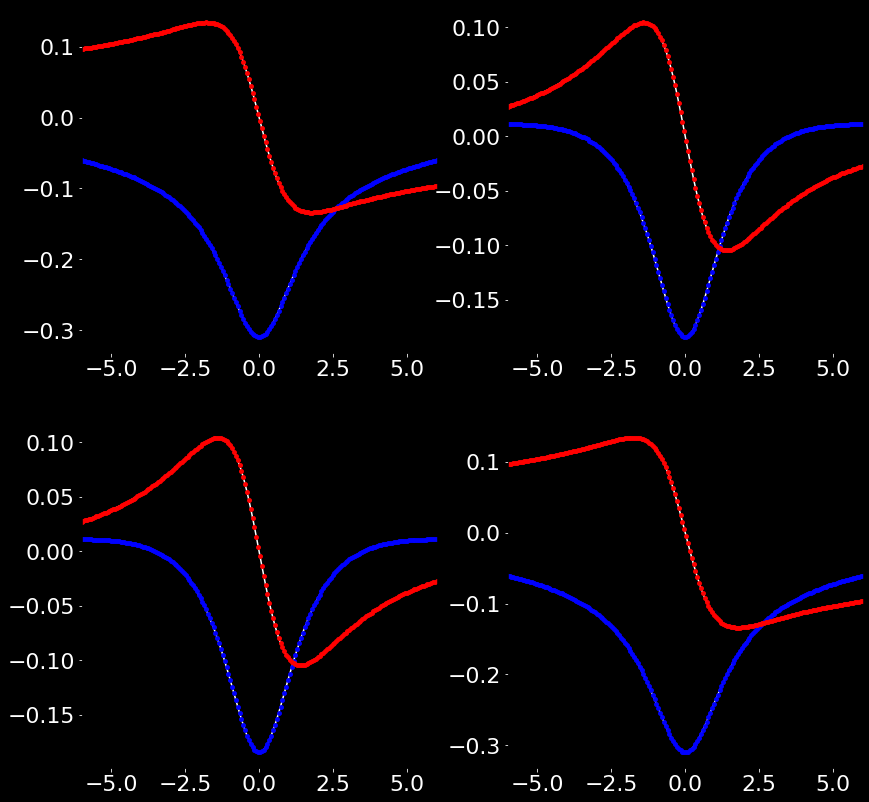

In [63]:
analytical(U = 10.0)

Chemical potential = 0
occupation g0_w: 1.9999999999999991
occupation g_w: 1.9464557209023219


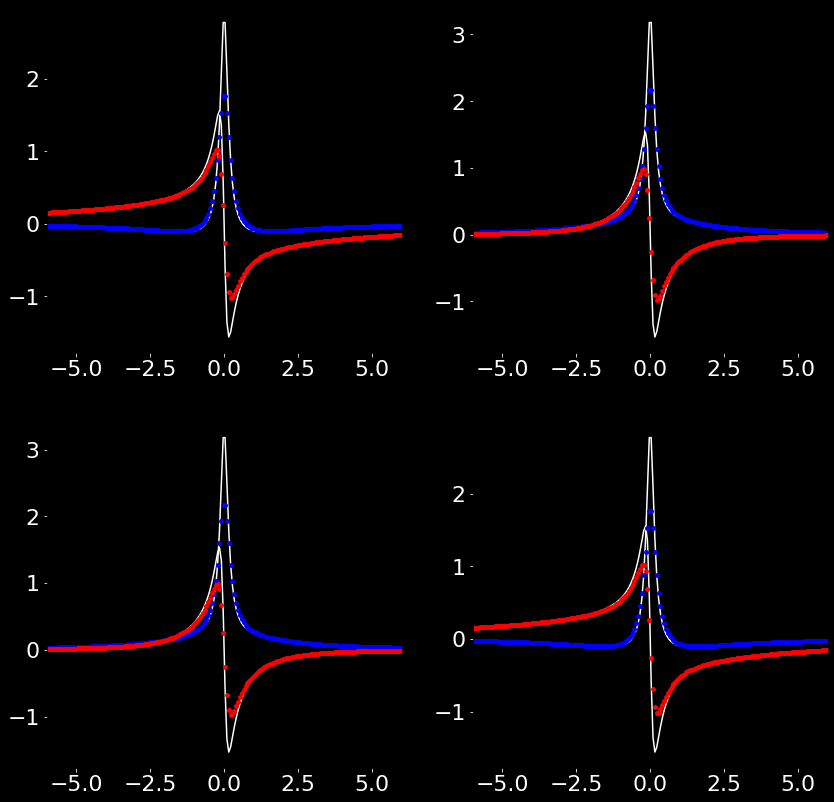

In [62]:
GWtoED(orbitals = 2, occupation = 2, U = 1.15, beta = 100, non_local = True, pade = False, fix_g0 = True, fix_g = False)

Chemical potential = 0
occupation g0_w: 1.9999999999999991
occupation g_w: 1.9694932163517536


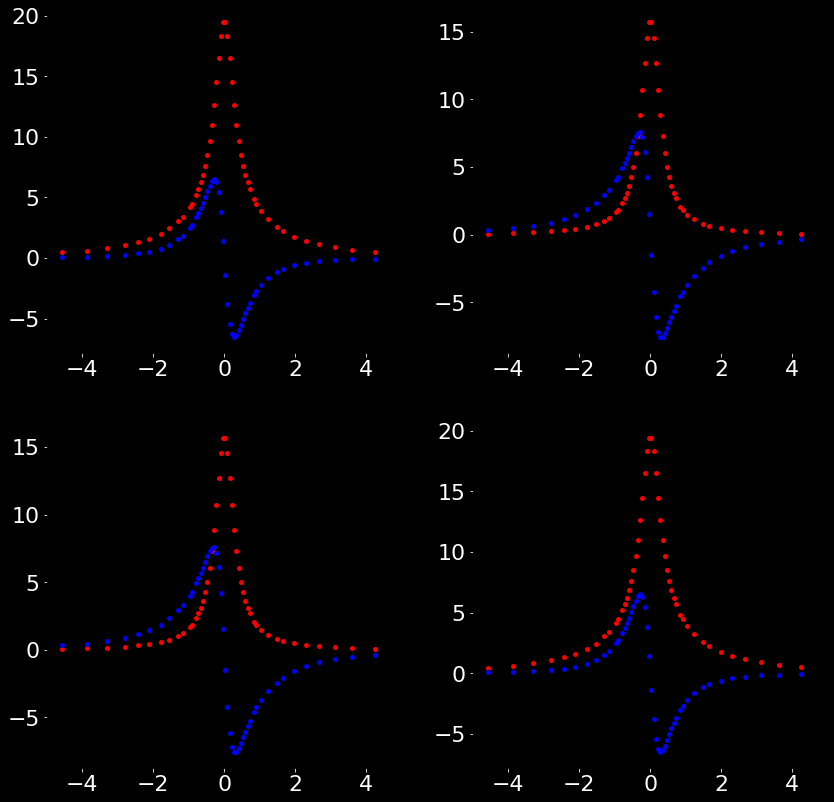

In [53]:
relativeErrors(orbitals = 2, occupation = 2, U = 1.0, beta = 100, non_local = True, fix_g0 = True, fix_g = False)

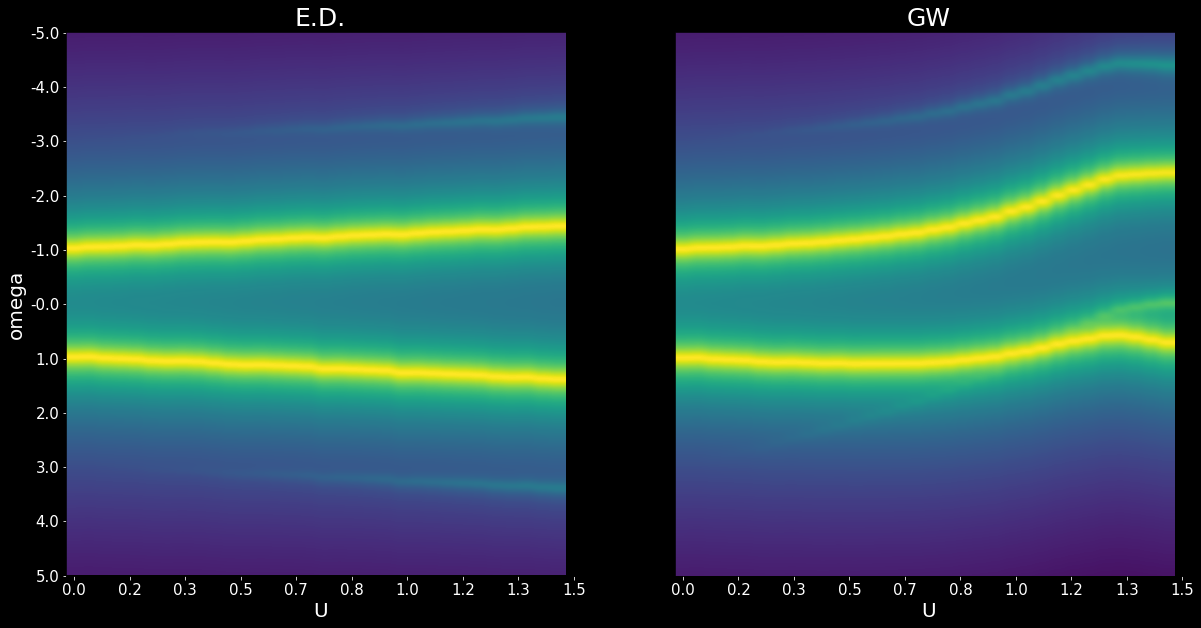

In [58]:
colorPlot(orbitals = 2, occupation = 2, non_local = True, beta = 100, fix_g0 = True, fix_g = False)

1.9996582298928516
2.0000002197249906


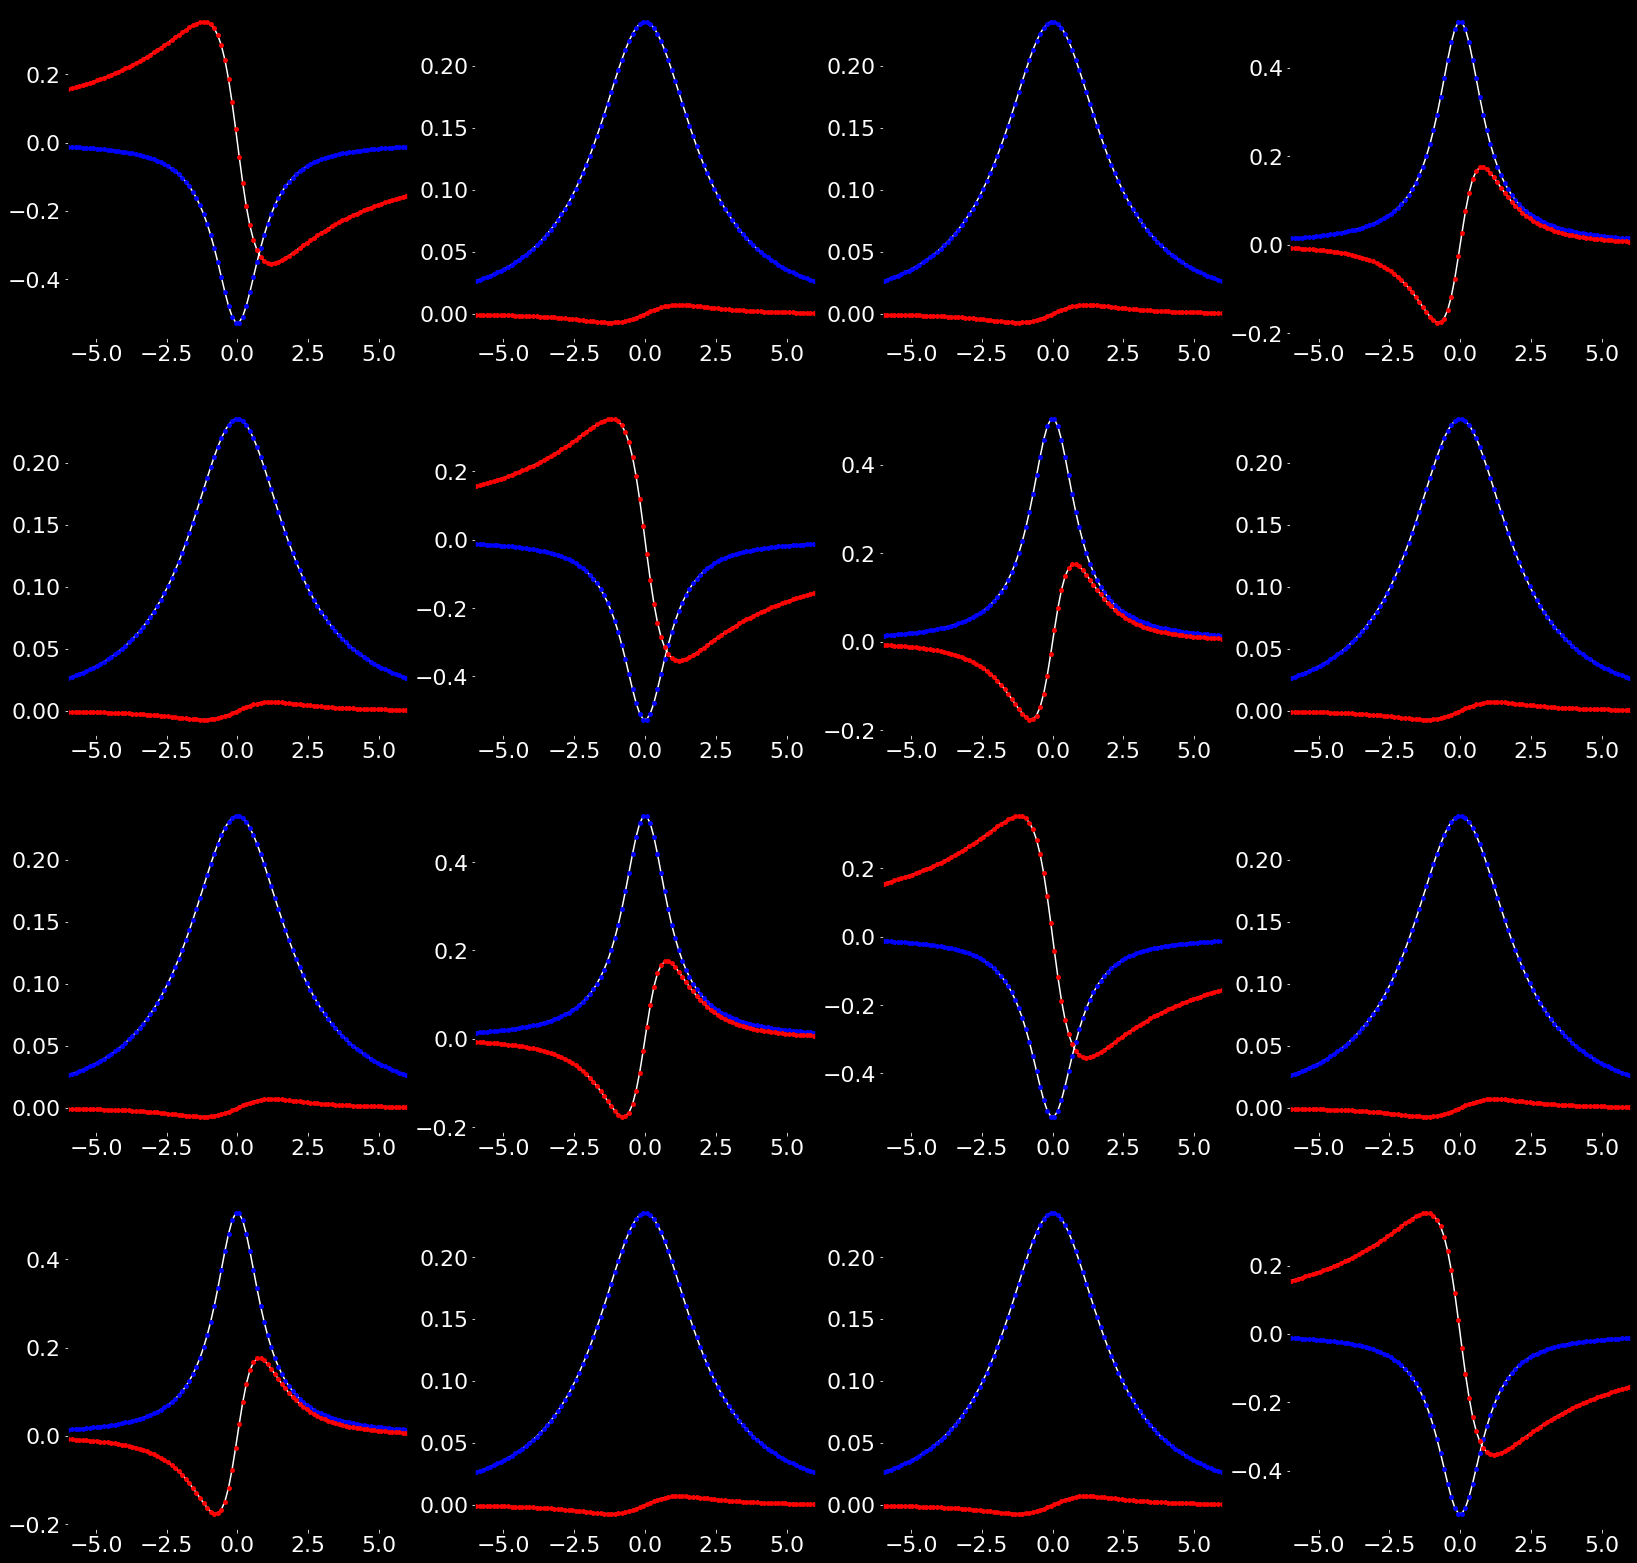

In [15]:
from triqs.gf import *
from triqs.operators import *
from triqs.operators.util.hamiltonians import h_int_slater
from triqs.operators.util import *
from triqs.operators.util.hamiltonians import *
from triqs.atom_diag import *


        
def dyson(g_w, mu):
    G = g_w.copy()
    mu_gf = g_w['up'].copy()
    mu_gf.data[:] = np.eye(g_w['up'].target_shape[0]) * mu
    for block, g in g_w:
        G[block] = (g_w[block].inverse() - mu_gf).inverse()
    return G


t = 1.0
U = 0.5
beta = 50

tij = -np.array([
    [0, t, t, t / 2],
    [t, 0, t / 2, t],
    [t, t / 2, 0, t],
    [t/2, t, t, 0]
])


Vij = np.array([
    [U, U / 2, U / 2, U / 4],
    [U / 2, U, U / 4, U / 2],
    [U / 2, U / 4, U, U / 2],
    [U / 4, U / 2, U / 2, U],
])

Vijkl = np.zeros([4] * 4)
for i in range(4):
    for j in range(4):
        Vijkl[i, j, i, j] = Vij[i, j]


iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion', w_max = 5.0, eps = 1e-15)


g0 = generate_g0_w(tij, iw_mesh_f)

gw = GWSolver(g0, Vij, self_interactions = False, hartree_flag = True, fock_flag = True, N_fix = 2, fix_g0 = True, fix_g = False, full_mesh = True)

spin_names = ['up', 'dn']
orbital_names = range(len(tij))
fundamental_operators = [(spin_name, orbital_name) for spin_name, orbital_name in product(spin_names, orbital_names)]

N = 0
for i in orbital_names:
    N += n('up', i) + n('dn', i)

H = h_int_slater(spin_names, len(orbital_names), Vijkl, off_diag = True, complex = True)
    
for spin, i, j in product(spin_names, orbital_names, orbital_names):
    H += tij[i, j] * c_dag(spin, i) * c(spin, j)
    

mu = 0
Hmu = H + mu * N

atomic_diagonal = AtomDiagComplex(Hmu, fundamental_operators)
gf_struct = [('dn', len(orbital_names)),
            ('up', len(orbital_names))]

G_iw = atomic_g_iw(atomic_diagonal, beta, gf_struct, 1024)

g_iw = dyson(gw.g_w, mu)

print(g_iw.total_density().real)
print(G_iw.total_density().real)

plot(g_iw, G_iw)

Chemical potential = 0
occupation g0_w: 2.0000000000002633
occupation g_w: 1.9962818403061453


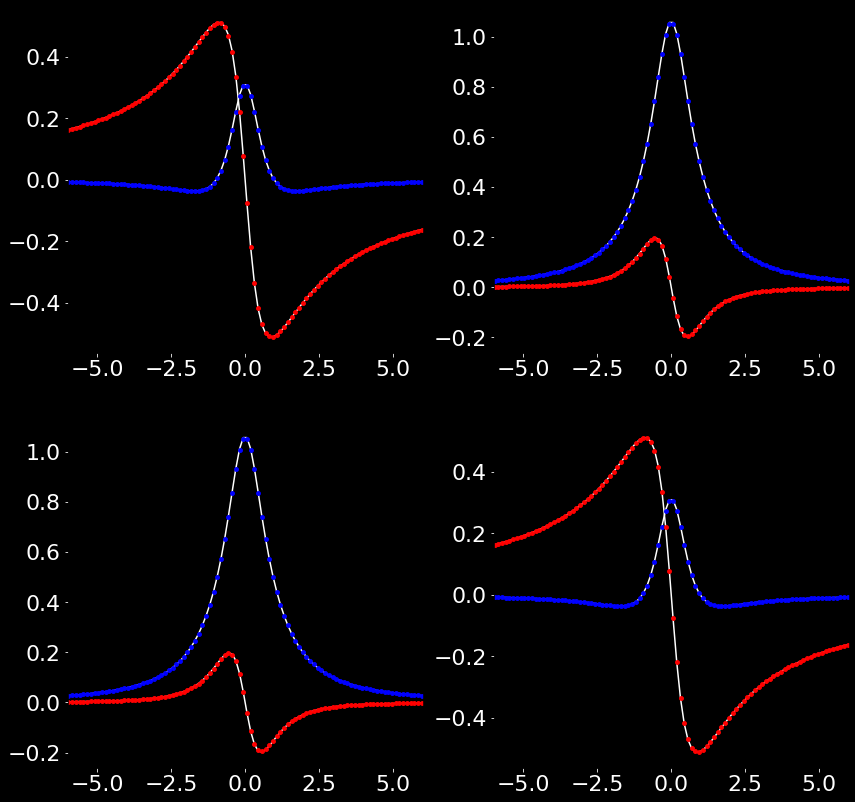

In [9]:
U = 0.6
t = 1.0
orbitals = 2
occupation = 2
non_local = False
beta = 50

tij = np.zeros([orbitals] * 2)
for i in range(orbitals - 1):
    tij[i, i + 1] = -t
    tij[i + 1, i] = -t

Vij = coulomb_matrix(orbitals, U, non_local = non_local)
Vijkl = coulomb_tensor(orbitals , U, non_local = non_local)

iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 5.0, eps = 1e-15)
g0_w = generate_g0_w(tij, iw_mesh_f)

gw = GWSolver(g0_w, Vij, self_interactions = False, hartree_flag = True, fock_flag = True, N_fix = occupation, fix_g0 = True, fix_g = False, print_occupation = True, full_mesh = True)
ED = exact_diag(tij, Vijkl, occupation, beta = beta, nw = 1024)


g_iw = dyson(gw.g_w, 0)
# print(g_iw.total_density().real)
plot(g_iw, ED)